In [1]:
# import standard libraries
import copy
import numpy as np
# import third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import local libraries

# Load data

In [2]:
# load data 
df = pd.read_csv('../data/customers.csv')

# Data cleaning

In [3]:
# convert column TotalCharges to numeric as done in Problem Set 1
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df = df.dropna(axis = 0, how = 'any')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


# Feature encoding

In [5]:
# set customerID to index since we are clearly not going to use this as a feature in our models
df = df.set_index('customerID')

In [6]:
# print possibe values for each categorical feature
for col in df:
    if df[col].dtype == 'object':
        print('{}: {}'.format(col, ', '.join(df[col].unique().tolist())))

gender: Female, Male
Partner: Yes, No
Dependents: No, Yes
PhoneService: No, Yes
MultipleLines: No phone service, No, Yes
InternetService: DSL, Fiber optic, No
OnlineSecurity: No, Yes, No internet service
OnlineBackup: Yes, No, No internet service
DeviceProtection: No, Yes, No internet service
TechSupport: No, Yes, No internet service
StreamingTV: No, Yes, No internet service
StreamingMovies: No, Yes, No internet service
Contract: Month-to-month, One year, Two year
PaperlessBilling: Yes, No
PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
Churn: No, Yes


In [7]:
# customers with no internet service
customers_nointernet = df[df['InternetService'] == 'No'].index

# check features of customers which have any value == 'No internet services' are the same customers where
# InternetService == 'No'
for col in df:
    if 'No internet service' in df[col].unique().tolist():
        error = customers_nointernet.difference(df[df[col] == 'No internet service'].index)
        assert error.empty # no assert error = good news

In [8]:
# create new column internet with binary values 1 yes, 0 no
df['Internet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
# same for DSL / Fiber optic
df['DSL'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)
df['FiberOptic'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)
# drop useless columns
df = df.drop(columns = 'InternetService')

In [9]:
# replace features with only two possible values with binary value. We know that if the customer has no 
# internet service then the customer will not have the service feature. The same goes for multiple lines.
binary_map = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0, 'Female': 0, 'Male': 1}
replace_dict = {'gender': binary_map,
                'Partner': binary_map,
                'Dependents': binary_map,
                'PhoneService': binary_map,
                'OnlineSecurity': binary_map,
                'OnlineBackup': binary_map,
                'DeviceProtection': binary_map,
                'TechSupport': binary_map,
                'StreamingTV': binary_map,
                'StreamingMovies': binary_map,
                'PaperlessBilling': binary_map,
                'Churn': binary_map,
                'MultipleLines': binary_map}
df = df.replace(replace_dict, inplace = False)
df = df.rename(columns = {'gender': 'Male'})

In [10]:
# still need to encode contract and payment method features, we use one hot encoding
dummies = pd.get_dummies(df[['Contract', 'PaymentMethod']], prefix = ['Contract',  'Payment'], prefix_sep = '=')
df = pd.concat([df, dummies], axis = 1)
df = df.drop(columns = ['Contract', 'PaymentMethod'])

In [11]:
# Finished encoding, all dtypes are either int or float
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Male                               7032 non-null   int64  
 1   SeniorCitizen                      7032 non-null   int64  
 2   Partner                            7032 non-null   int64  
 3   Dependents                         7032 non-null   int64  
 4   tenure                             7032 non-null   int64  
 5   PhoneService                       7032 non-null   int64  
 6   MultipleLines                      7032 non-null   int64  
 7   OnlineSecurity                     7032 non-null   int64  
 8   OnlineBackup                       7032 non-null   int64  
 9   DeviceProtection                   7032 non-null   int64  
 10  TechSupport                        7032 non-null   int64  
 11  StreamingTV                        7032 non-nu

# Feature selection

In [12]:
# Irrelevant or partially relevant features can negatively impact model performance
# This is why we need to go through feature selection.

In [13]:
# separate exo/indogenoeous variables
X, y = df.drop(columns = 'Churn'), df[['Churn']]
y = y['Churn'].astype(int) #required otherwise Value error in selector_kbest.fit()

## SelectKBest

In [14]:
# use the selet k best method from sklearn and evaluate with the chi squared function
selector_kbest = SelectKBest(score_func = chi2, k = 'all')
selector_kbest.fit(X, y)
mask_kbest = selector_kbest.get_support(indices = False)
features_kbest = pd.Series(data = selector_kbest.scores_, index = X.columns)
features_kbest_sorted = features_kbest.sort_values(ascending = False)

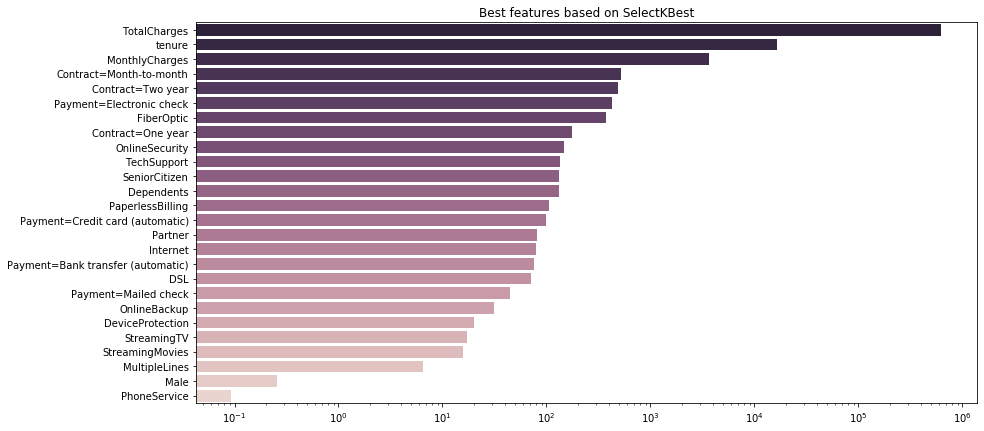

In [15]:
# show features from best to worst (mind the log scale)
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_kbest_sorted.index, x = features_kbest_sorted.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_kbest), reverse = True))
ax.set_xscale("log")
ax.set_title('Best features based on SelectKBest')
plt.show()

## ExtraTreesClassifier

In [16]:
# use the extra trees classifire from sklearn
selector_trees_gini = ExtraTreesClassifier(criterion = 'gini', min_samples_leaf = 10)
selector_trees_gini.fit(X, y)
features_trees_gini = pd.Series(data = selector_trees_gini.feature_importances_, index = X.columns)
features_trees_sorted_gini = features_trees_gini.sort_values(ascending = False)

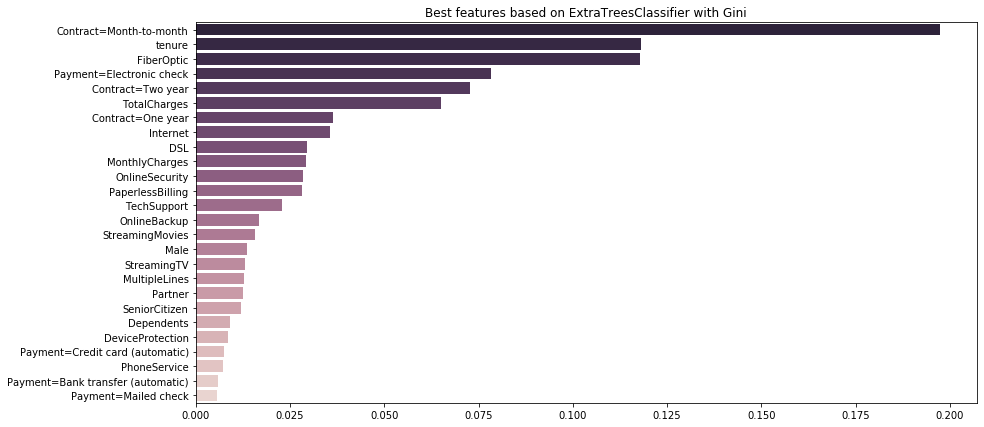

In [17]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_gini.index, x = features_trees_sorted_gini.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_gini), reverse = True))
ax.set_title('Best features based on ExtraTreesClassifier with Gini')
plt.show()

In [18]:
# use the extra trees classifire from sklearn
selector_trees_entropy = ExtraTreesClassifier(criterion = 'entropy', min_samples_leaf = 10)
selector_trees_entropy.fit(X, y)
features_trees_entropy = pd.Series(data = selector_trees_entropy.feature_importances_, index = X.columns)
features_trees_sorted_entropy = features_trees_entropy.sort_values(ascending = False)

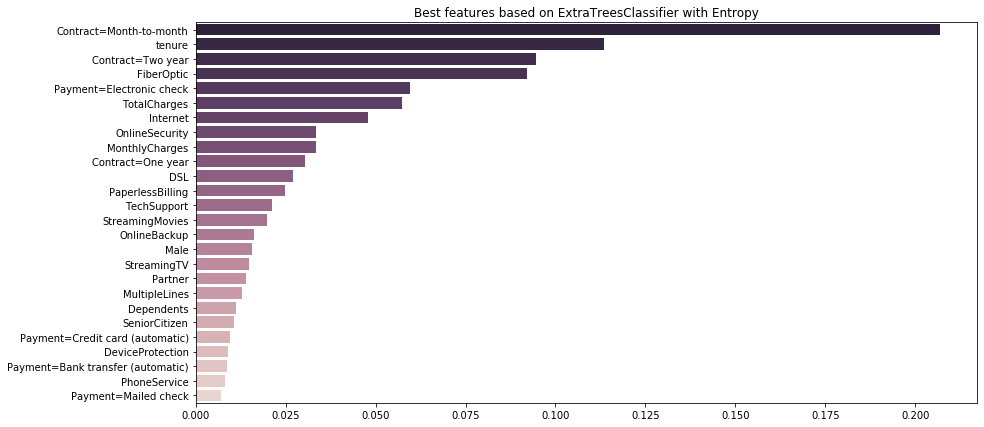

In [19]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_entropy.index, x = features_trees_sorted_entropy.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_entropy), reverse = True))
ax.set_title('Best features based on ExtraTreesClassifier with Entropy')
plt.show()

## Correlation matrix

In [20]:
corr_matrix_kendall = df.corr('kendall')
corr_matrix_pearson = df.corr()

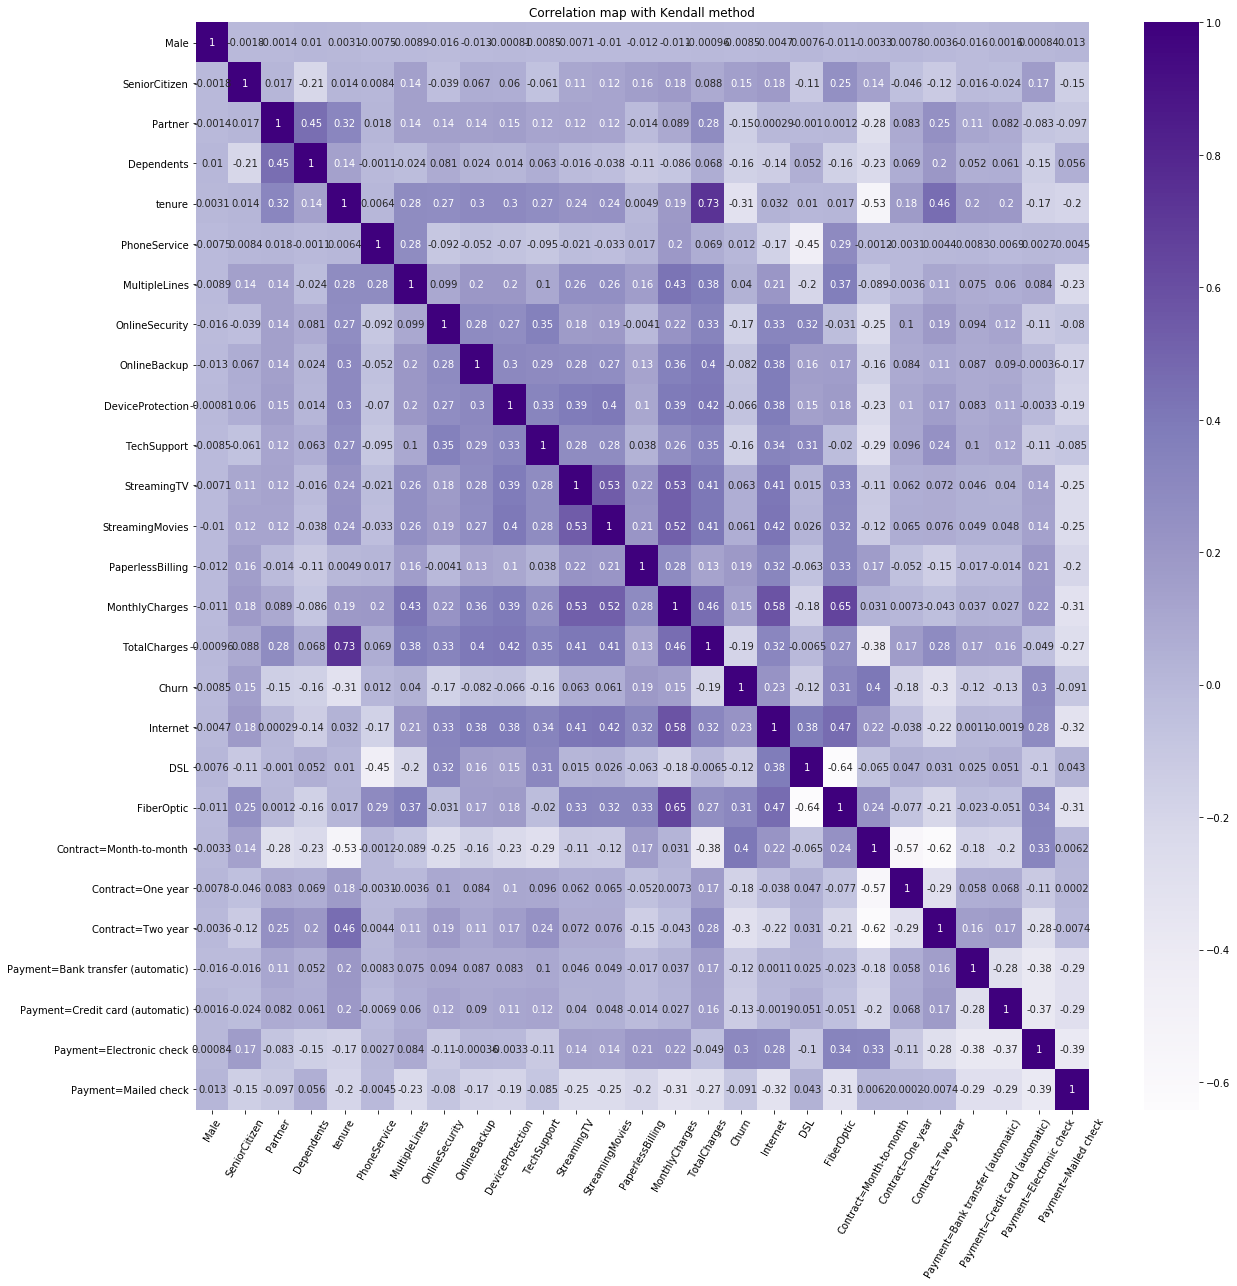

In [21]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(corr_matrix_kendall, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Kendall method')
plt.show()

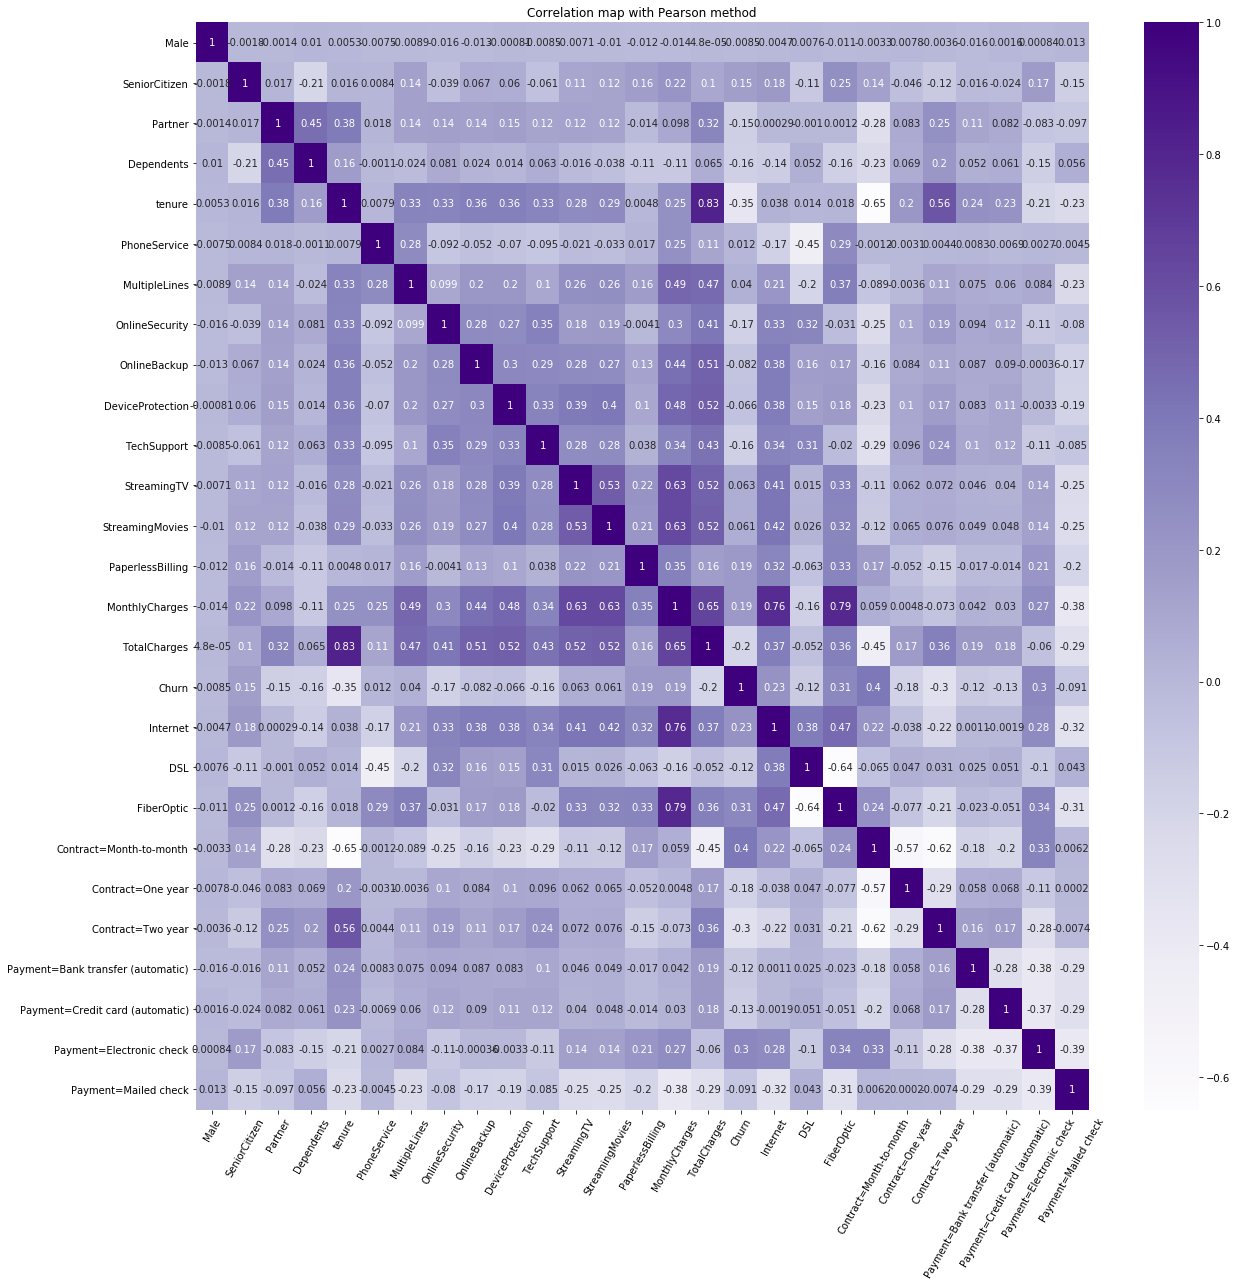

In [22]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(corr_matrix_pearson, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Pearson method')
plt.show()

All three methods of feature selection seem to point that the following features are relevant when modelling (more or less)
* Contract=Month-to-month
* Payment=Electronic check
* FiberOptic
* MonthlyCharges
* tenure
* TotalCharges
* Contract=Two year

## Transform

In [25]:
# custom selection
selected_features = [
    #'Male', 
    #'SeniorCitizen', 
    #'Partner', 
    #'Dependents', 
    'tenure',
    #'PhoneService', 
    #'MultipleLines', 
    #'OnlineSecurity', 
    #'OnlineBackup',
    #'DeviceProtection', 
    #'TechSupport', 
    #'StreamingTV', 
    #'StreamingMovies',
    #'PaperlessBilling', 
    'MonthlyCharges', 
    'TotalCharges', 
    #'Internet', 
    #'DSL',
    'FiberOptic', 
    'Contract=Month-to-month', 
    #'Contract=One year',
    #'Contract=Two year', 
    #'Payment=Bank transfer (automatic)',
    #'Payment=Credit card (automatic)', 
    #'Payment=Electronic check',
    #'Payment=Mailed check'
]

# selection from algorithm
selected_features_kbest = features_kbest_sorted.index[0:5]
selected_features_gini = features_trees_sorted_gini.index[0:5]
selected_features_entropy = features_trees_sorted_entropy.index[0:5]

features = [selected_features, selected_features_kbest, selected_features_gini, selected_features_entropy]

# Predicting churn

## Scaling the data

In [26]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1)) # reasonable since most categorial variables are either 0 or 1
min_max_scaler = min_max_scaler.fit(df)
df_min_max = min_max_scaler.transform(df)
df_min_max = pd.DataFrame(data = df_min_max, columns = df.columns, index = df.index)

## K-Neighbors classifier

In [27]:
# define grid parameters to use for gridsearch
param_grid_kneigh = {'weights': ('uniform', 'distance'),
                    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute')
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_kneigh = GridSearchCV(KNeighborsClassifier(n_neighbors = y.nunique()),
                                param_grid = param_grid_kneigh,
                                scoring = 'accuracy',
                                cv = 10
                                )

## Random Tree

In [28]:
# define grid parameters to use for gridsearch
param_grid_trees = {'max_depth': [1, 5, 10, 50, 100, 200],
                    'min_samples_split': [2, 4, 8, 16],
                    'min_samples_leaf': [1, 5, 10, 50, 100, 200],
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_trees = GridSearchCV(DecisionTreeClassifier(),
                                param_grid = param_grid_trees,
                                scoring = 'accuracy',
                                cv = 10
                                )

## Random Forest

In [29]:
# define grid parameters to use for gridsearch
param_grid_forest = {'n_estimators': [100],
                     'max_depth': [1, 5, 10, 50],
                     'min_samples_split': [2, 4, 8],
                     'min_samples_leaf': [10, 50, 100, 200],
                     }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation
classifier_forest = GridSearchCV(RandomForestClassifier(),
                                 param_grid = param_grid_forest,
                                 scoring = 'accuracy',
                                 cv = 10
                                 )

## Support Vector Machine 

In [30]:
# define grid parameters to use for gridsearch
param_grid_svc = {'C': [1, 10, 100, 1000], 
                  'gamma': [0.001, 0.0001],
                 }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_svc = GridSearchCV(SVC(kernel = 'rbf'),
                              param_grid = param_grid_svc,
                              scoring = 'accuracy',
                              cv = 10
                              )

## Split train/test set

In [31]:
# split 80/20 ratio 
score_kneight = []
score_trees = []
score_forest = []
score_svc = []
#test for all methods 
for f in features: 
    X_feat_min_max = df_min_max[f]
    X_train, X_test, y_train, y_test = train_test_split(X_feat_min_max, y, test_size = 0.2, stratify = y)
    
    classifier_kneigh.fit(X_train, y_train)
    classifier_trees.fit(X_train, y_train)
    classifier_forest.fit(X_train, y_train)
    classifier_svc.fit(X_train, y_train)
    
    score_kneight.append(classifier_kneigh.score(X_test, y_test))
    score_trees.append(classifier_trees.score(X_test, y_test))
    score_forest.append(classifier_forest.score(X_test,y_test))
    score_svc.append(classifier_svc.score(X_test, y_test))

In [32]:
index = ['Manual','Kbest', 'Gini', 'Entropy']

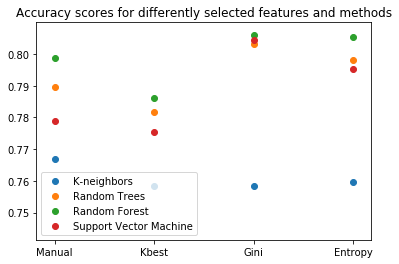

In [33]:
plt.scatter(index, score_kneight)
plt.scatter(index, score_trees)
plt.scatter(index, score_forest)
plt.scatter(index, score_svc)
plt.legend(['K-neighbors', 'Random Trees', 'Random Forest', 'Support Vector Machine'], loc='lower left')
plt.title('Accuracy scores for differently selected features and methods')
plt.show()